# __Movie Sentiment Analysis__

In [259]:
import pandas as pd
import numpy as np
import re
import contractions
import nltk
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import text_preprocessing as tp
import utils
import spacy
import seaborn as sb

from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from flashtext import KeywordProcessor
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import accuracy_score, classification_report

warnings.filterwarnings("ignore")

## Importing Dataset for Movie Metadata

Use the IMDB dataset containing information about movies. Two different data sources will be utilized in the process of traning the model.

__a. Data Source:__ https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/

In [260]:
# Open file containing movie metadata
movies_metadata_df = pd.read_csv("./dataset/movies_metadata.csv")
movies_metadata_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,10/30/1995,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,12/15/1995,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,12/22/1995,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,12/22/1995,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,2/10/1995,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [261]:
# Open file containing the movie credits, i.e. casts and crews
movies_credits_df = pd.read_csv("./dataset/credits.csv")
movies_credits_df.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [262]:
# Combine the dataframes of movie metadata and credits
movies_metadata_df = pd.merge(movies_metadata_df, movies_credits_df, on=["id"], how="left")
movies_metadata_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [263]:
# List all the columns in movie metadata's dataframe
movies_metadata_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew'],
      dtype='object')

In [264]:
# Drop columns that are not relevant
del_columns = ['belongs_to_collection', 'homepage', 'id', 'original_language', 'original_title', 'popularity', 'poster_path', 'adult',
               'overview', 'tagline', 'production_countries', 'spoken_languages', 'status', 'video', 'vote_average', 'vote_count']
movies_metadata_df = movies_metadata_df.drop(del_columns, axis=1)

# Remove 'tt' appended on the IMDB ID
movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].apply(lambda x : x[2:] if isinstance(x, str) and "tt" in x else x)

movies_metadata_df.head(5)

,budget,genres,imdb_id,production_companies,release_date,revenue,runtime,title,cast,crew
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",0114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",10/30/1995,373554033.0,81.0,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",0113497,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",12/15/1995,262797249.0,104.0,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",0113228,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",12/22/1995,0.0,101.0,Grumpier Old Men,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",0114885,[{'name': 'Twentieth Century Fox Film Corporat...,12/22/1995,81452156.0,127.0,Waiting to Exhale,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,0,"[{'id': 35, 'name': 'Comedy'}]",0113041,"[{'name': 'Sandollar Productions', 'id': 5842}...",2/10/1995,76578911.0,106.0,Father of the Bride Part II,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


__b. Data Source:__ https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp/data

In [265]:
# Open another file containing the movie metadata
movies_df = pd.read_csv("./dataset/movies.csv")
movies_df.head(5)

,imdbId,Imdb Link,Title,IMDB Score,Genre,local_image_path
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation;Adventure;Comedy,images/114709_.jpg
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action;Adventure;Family,images/113497_.jpg
2,113277,http://www.imdb.com/title/tt113277,Heat (1995),8.2,Action;Crime;Drama,images/113277_.jpg
3,114319,http://www.imdb.com/title/tt114319,Sabrina (1995),6.3,Comedy;Drama,images/114319_.jpg
4,114576,http://www.imdb.com/title/tt114576,Sudden Death (1995),5.7,Action;Crime;Thriller,images/114576_.jpg


In [266]:
# Rename the column names of movies info by removing the spaces and converting to lower case
movies_df = movies_df.rename(columns={"imdbId" : "imdb_id", "Imdb Link" : "imbd_link", "Title" : "movie", "IMDB Score" : "imdb_score", "Genre" : "genre"})
print(movies_df.columns)

Index(['imdb_id', 'imbd_link', 'movie', 'imdb_score', 'genre',
       'local_image_path'],
      dtype='object')


In [267]:
# Drop columns that are not relevant
del_columns = ['imbd_link', 'imdb_score', 'local_image_path']

movies_df = movies_df.drop(columns=del_columns, axis=1)
movies_df.head(5)

,imdb_id,movie,genre
0,114709,Toy Story (1995),Animation;Adventure;Comedy
1,113497,Jumanji (1995),Action;Adventure;Family
2,113277,Heat (1995),Action;Crime;Drama
3,114319,Sabrina (1995),Comedy;Drama
4,114576,Sudden Death (1995),Action;Crime;Thriller


In [268]:
# Merge two different datasets for movies metadata

movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].fillna(0) # fixed errors on NaN values when converting to int data type
movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].astype(int)

movies_metadata_df = pd.merge(movies_metadata_df, movies_df, on=["imdb_id"], how="right")
movies_metadata_df.head(5)

,budget,genres,imdb_id,production_companies,release_date,revenue,runtime,title,cast,crew,movie,genre
0,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",10/30/1995,373554033.0,81.0,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",Toy Story (1995),Animation;Adventure;Comedy
1,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",113497,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",12/15/1995,262797249.0,104.0,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",Jumanji (1995),Action;Adventure;Family
2,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",113277,"[{'name': 'Regency Enterprises', 'id': 508}, {...",12/15/1995,187436818.0,170.0,Heat,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...",Heat (1995),Action;Crime;Drama
3,58000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",114319,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",12/15/1995,0.0,127.0,Sabrina,"[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de...",Sabrina (1995),Comedy;Drama
4,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",114576,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",12/22/1995,64350171.0,106.0,Sudden Death,"[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...",Sudden Death (1995),Action;Crime;Thriller


## Importing Dataset for Movie Reviews

Use the IMDB dataset for movie reviews.

__Data Source:__ https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp/data

In [269]:
# Open the file containing the movie reviews
reviews_df = pd.read_csv("./dataset/reviews.csv")
reviews_df.head(5)

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful,roberta_sentiment
0,rw0213367,SUPERNOVA HEIGHTS,A Nightmare on Elm Street (1984),8.0,A Classic of the horror films History,27-Aug-03,0,This is the beginning of a great horror film s...,"['0', '0']",Positive
1,rw0213369,kibler@adelphia.net,A Nightmare on Elm Street (1984),NaN,Better than your average horror movie,01-Sep-03,0,"Nightmare on Elm Street, A (1984) John Saxon, ...","['0', '0']",Negative
2,rw0213371,matthew87,A Nightmare on Elm Street (1984),NaN,good slasher flick,01-Sep-03,0,"the best freddy film period,1 because the horr...","['0', '0']",Positive
3,rw0213375,rossrobinson,A Nightmare on Elm Street (1984),10.0,A nightmare on elm st part 1,27-Sep-03,0,I remember seeing a nightmare on elm street pa...,"['0', '2']",Negative
4,rw0213376,Andres24,A Nightmare on Elm Street (1984),9.0,Highway to hell,03-Oct-03,0,"It's a nightmare. If Nancy falls asleep, they...","['1', '1']",Positive


In [270]:
# Merge the movie metadata (from the same kaggle source) and reviews
movie_reviews_df = pd.merge(movies_df, reviews_df, on=["movie"], how="inner")
movie_reviews_df.head(5)

,imdb_id,movie,genre,review_id,reviewer,rating,review_summary,review_date,spoiler_tag,review_detail,helpful,roberta_sentiment
0,114709,Toy Story (1995),Animation;Adventure;Comedy,rw1223346,KUAlum26,10.0,Can it be ten years already?,23-Nov-05,0,PIXAR animation was but an experimental animat...,"['1', '1']",Positive
1,114709,Toy Story (1995),Animation;Adventure;Comedy,rw3110243,MUFCOK,10.0,A childhood favourite,24-Oct-14,0,Toy Story is one of those movies which holds a...,"['1', '2']",Positive
2,114709,Toy Story (1995),Animation;Adventure;Comedy,rw3109622,Rainey-Dawn,6.0,Not As Good As I Was Hoping,23-Oct-14,0,"This is another one of my ""I should like this ...","['2', '8']",Neutral
3,114709,Toy Story (1995),Animation;Adventure;Comedy,rw3124846,byson5186,9.0,Why The First Toy Story Is My Favorite,15-Nov-14,0,So far they have come out with 3 Toy Story mov...,"['0', '1']",Positive
4,114709,Toy Story (1995),Animation;Adventure;Comedy,rw3635799,snperera,9.0,A classic friendship story!,08-Feb-17,0,"Wow, well what can I say! This is a favorite o...","['0', '1']",Positive


In [271]:
# Drop columns that are not relevant, including the movie and genre. IMDB ID can be used to associate 
# review records with movie metadata
del_columns = ['movie', 'genre', 'review_id', 'reviewer', 'spoiler_tag', 'helpful', 'rating']

movie_reviews_df = movie_reviews_df.drop(columns=del_columns, axis=1)
movie_reviews_df.head(5)

,imdb_id,review_summary,review_date,review_detail,roberta_sentiment
0,114709,Can it be ten years already?,23-Nov-05,PIXAR animation was but an experimental animat...,Positive
1,114709,A childhood favourite,24-Oct-14,Toy Story is one of those movies which holds a...,Positive
2,114709,Not As Good As I Was Hoping,23-Oct-14,"This is another one of my ""I should like this ...",Neutral
3,114709,Why The First Toy Story Is My Favorite,15-Nov-14,So far they have come out with 3 Toy Story mov...,Positive
4,114709,A classic friendship story!,08-Feb-17,"Wow, well what can I say! This is a favorite o...",Positive


## Exploratory Data Analysis

Check and resolve duplicate records

In [272]:
# Drop duplicate records in movies metadata
print(f"Record count before removing duplicates => {movies_metadata_df.shape[0]}")
movies_metadata_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {movies_metadata_df.shape[0]}")

Record count before removing duplicates => 4174
Record count after removing duplicates  => 4071


In [273]:
# Drop duplicate records in movies reviews
print(f"Record count before removing duplicates => {movie_reviews_df.shape[0]}")
movie_reviews_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {movie_reviews_df.shape[0]}")

Record count before removing duplicates => 538381
Record count after removing duplicates  => 524520


Check and resolve missing values for `movie metadata`

In [274]:
# Check for missing values in movies metadata
movies_metadata_df.isna().sum()

budget                  3
genres                  3
imdb_id                 0
production_companies    3
release_date            3
revenue                 3
runtime                 3
title                   3
cast                    3
crew                    3
movie                   0
genre                   0
dtype: int64

In [275]:
# List of movies with missing information
movies_metadata_df[movies_metadata_df['title'].isna()]

,budget,genres,imdb_id,production_companies,release_date,revenue,runtime,title,cast,crew,movie,genre
2780,NaN,NaN,462322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grindhouse (2007),Action;Horror;Thriller
3521,NaN,NaN,448694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puss in Boots (2011),Animation;Action;Adventure
3793,NaN,NaN,1937390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nymphomaniac: Vol. I (2013),Drama


In [276]:
# Drop all movies with missing information
movies_metadata_df.dropna(inplace=True, axis=0)
movies_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4068 entries, 0 to 4173
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4068 non-null   float64
 1   genres                4068 non-null   object 
 2   imdb_id               4068 non-null   int64  
 3   production_companies  4068 non-null   object 
 4   release_date          4068 non-null   object 
 5   revenue               4068 non-null   float64
 6   runtime               4068 non-null   float64
 7   title                 4068 non-null   object 
 8   cast                  4068 non-null   object 
 9   crew                  4068 non-null   object 
 10  movie                 4068 non-null   object 
 11  genre                 4068 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 413.2+ KB


Check and resolve missing values for `movie reviews`

In [277]:
# Check for missing values in movies reviews
movie_reviews_df.isna().sum()

imdb_id              0
review_summary       1
review_date          0
review_detail        0
roberta_sentiment    0
dtype: int64

In [278]:
# Replace all missing values in review summary and detail with a blank
movie_reviews_df[['review_summary', 'review_detail']] = movie_reviews_df[['review_summary', 'review_detail']].fillna('')
movie_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 524520 entries, 0 to 538380
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   imdb_id            524520 non-null  int64 
 1   review_summary     524520 non-null  object
 2   review_date        524520 non-null  object
 3   review_detail      524520 non-null  object
 4   roberta_sentiment  524520 non-null  object
dtypes: int64(1), object(4)
memory usage: 24.0+ MB


#### __Data Wrangling and Visualizations__:

Conduct data wrangling on `movie metadata` to transform and structure data into a desired format

In [279]:
# Separate movie release year from the title
pattern_year = r'\((\d{4})\)$'
movies_metadata_df['release_year'] = movies_metadata_df['movie'].str.extract(pattern_year).astype(int)
movies_metadata_df['movie'] = movies_metadata_df['movie'].str.replace(pattern_year, '', regex=True).str.strip()
movies_metadata_df[['movie', 'release_year']].head(5)

# Drop columns containing duplicate movie information
dup_columns = ['genres', 'release_date', 'title']
movies_metadata_df = movies_metadata_df.drop(columns=dup_columns, axis=1)

# Rearrange the order of columns
desired_order = ['imdb_id', 'movie', 'release_year', 'genre', 'runtime', 'budget', 'revenue', 'production_companies', 'cast', 'crew']
movies_metadata_df = movies_metadata_df[desired_order]

movies_metadata_df.head(5)

,imdb_id,movie,release_year,genre,runtime,budget,revenue,production_companies,cast,crew
0,114709,Toy Story,1995,Animation;Adventure;Comedy,81.0,30000000.0,373554033.0,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,113497,Jumanji,1995,Action;Adventure;Family,104.0,65000000.0,262797249.0,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,113277,Heat,1995,Action;Crime;Drama,170.0,60000000.0,187436818.0,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
3,114319,Sabrina,1995,Comedy;Drama,127.0,58000000.0,0.0,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de..."
4,114576,Sudden Death,1995,Action;Crime;Thriller,106.0,35000000.0,64350171.0,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de..."


In [280]:
# Convert genre into list data type
movies_metadata_df['genre'] = movies_metadata_df['genre'].apply(lambda x : x.split(";"))

# Convert to a list of production companies
movies_metadata_df['production_companies'] = movies_metadata_df['production_companies'].apply(lambda x : utils.convert_str_to_dict(x, ['name']))
movies_metadata_df['production_companies'] = movies_metadata_df['production_companies'].apply(lambda list_of_dicts : [value for d in list_of_dicts for value in d.values()])

# TODO: Need to fix the issue on cast and crew with names containing single quotation
# movies_metadata_df['cast'] = movies_metadata_df['cast'].apply(lambda x : utils.convert_str_to_dict(x, ['character', 'name']))

movies_metadata_df[['genre', 'production_companies', 'cast', 'crew']].head(5)

,genre,production_companies,cast,crew
0,"[Animation, Adventure, Comedy]",[Pixar Animation Studios],"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,"[Action, Adventure, Family]","[TriStar Pictures, Teitler Film, Interscope Co...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,"[Action, Crime, Drama]","[Regency Enterprises, Forward Pass, Warner Bros.]","[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
3,"[Comedy, Drama]","[Paramount Pictures, Scott Rudin Productions, ...","[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de..."
4,"[Action, Crime, Thriller]","[Universal Pictures, Imperial Entertainment, S...","[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de..."


Conduct data wrangling on `movie review` to transform and structure data into a desired format

In [281]:
# Get only the year the review was created
movie_reviews_df['review_year'] = pd.to_datetime(movie_reviews_df['review_date']).dt.year
movie_reviews_df = movie_reviews_df.drop(columns=['review_date'], axis=1)

movie_reviews_df.head(5)

,imdb_id,review_summary,review_detail,roberta_sentiment,review_year
0,114709,Can it be ten years already?,PIXAR animation was but an experimental animat...,Positive,2005
1,114709,A childhood favourite,Toy Story is one of those movies which holds a...,Positive,2014
2,114709,Not As Good As I Was Hoping,"This is another one of my ""I should like this ...",Neutral,2014
3,114709,Why The First Toy Story Is My Favorite,So far they have come out with 3 Toy Story mov...,Positive,2014
4,114709,A classic friendship story!,"Wow, well what can I say! This is a favorite o...",Positive,2017


Perform additional analysis of the data and create visual representations to gain a better understanding of the movie metadata and reviews. This information provides insights on trends and patterns in the movie data, which might be important especially on the reports that will be provided to the client.

In [282]:
# Show statistical summary of movie metadata and reviews
pd.merge(movies_metadata_df, movie_reviews_df, on=["imdb_id"], how="inner").describe()

,imdb_id,release_year,runtime,budget,revenue,review_year
count,5.244020e+05,524402.000000,524402.000000,5.244020e+05,5.244020e+05,524402.000000
mean,5.567062e+05,1995.708382,112.396383,4.177791e+07,1.530821e+08,2009.873698
std,7.600004e+05,18.310265,22.419268,5.306010e+07,2.429492e+08,6.264964
min,4.170000e+02,1902.000000,0.000000,0.000000e+00,0.000000e+00,1998.000000
25%,9.595600e+04,1988.000000,97.000000,3.500000e+06,1.029760e+07,2005.000000
50%,2.534740e+05,2002.000000,109.000000,2.100000e+07,6.127687e+07,2010.000000
75%,4.934640e+05,2008.000000,124.000000,6.000000e+07,1.861671e+08,2015.000000
max,5.247022e+06,2017.000000,254.000000,3.800000e+08,2.787965e+09,2021.000000


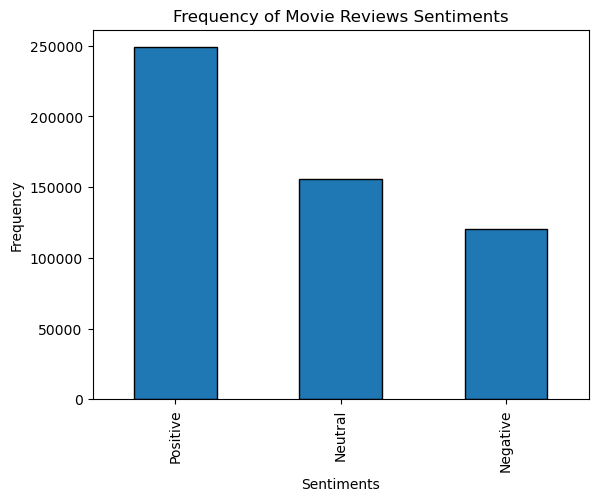

In [283]:
# Get the frequency of values in the 'roberta_sentiment' column
sentiment_counts = movie_reviews_df['roberta_sentiment'].value_counts()
sentiment_counts.plot(kind='bar', edgecolor='black')

plt.xlabel('Sentiments')
plt.ylabel('Frequency')
plt.title('Frequency of Movie Reviews Sentiments')
plt.show()

#### __For Text Pre-processing__:

__The movie summary and reviews undergo the following steps during the initial data pre-processing stage__
- Remove non-grammatical text like emails and URLs
- Replace non-ascii characters (some Python libraries are only limited to ascii characters like KeywordProcessor)
- Replace emojis with English word/s
- Handle contractions
- Handle slang words

In [284]:
# emoji_dict = tp.get_emojis()
# slang_word_dict = tp.get_slang_words(webscraped=False)

# def initial_text_preprocessing(text):
#     try:
#         # Remove non-grammatical text
#         text = tp.remove_email_address(text)
#         text = tp.remove_hyperlink(text)

#         # Replace non-ascii characters as there are Python libraries limiting this feature
#         text = tp.replace_nonascii_characters(text)

#         # Replace emojis with English word/s
#         text = emoji_dict.replace_keywords(text)

#         # Handle contractions
#         text = contractions.fix(text)

#         # Replace slang words
#         text = slang_word_dict.replace_keywords(text)

#     except Exception as err:
#         print(f"ERROR: {err}")
#         print(f"Input Text: {text}")

#     return text


# movie_reviews_df[['cleaned_review_summary', 'cleaned_review_detail']] = movie_reviews_df[['review_summary', 'review_detail']].applymap(initial_text_preprocessing)

# # Display the comparison between the top 5 original review summaries and their cleaned versions
# for i in range(5):
#     print("Original Review Summary:")
#     print(movie_reviews_df['review_summary'][i])
#     print("\nCleaned Review Summary:")
#     print(movie_reviews_df['cleaned_review_summary'][i])
#     print("="*100)

# # Display the comparison between the top 5 original review details and their cleaned versions
# for i in range(5):
#     print("Original Review Details:")
#     print(movie_reviews_df['review_detail'][i])
#     print("\nCleaned Review Details:")
#     print(movie_reviews_df['cleaned_review_detail'][i])
#     print("="*100)

__Name Entity Recognition (NER)__

In [285]:
# # TODO: Train own NER with the names of crews and casts and other important info

# # Load the English language model in spaCy
# nlp = spacy.load("en_core_web_sm")

# # Create a new dataFrame to store extracted name entitiesm then combine/rename the following labels
# # - LOCATION : GPE, LOC and FACE
# # - DATE_TIME : DATE, TIME
# # - ORGANIZATION : ORG

# column_names = ['PERSON', 'WORK_OF_ART', 'LOCATION', 'DATE_TIME', 'ORGANIZATION', 'PRODUCT', 'EVENT', 'LANGUAGE']
# movie_name_entities_df = pd.DataFrame(columns=column_names)

# # Extract and remove name entities from 'cleaned_review_summary' and 'cleaned_review_detail' columns
# movie_reviews_df['cleaned_review_summary'], movie_name_entities_df = tp.extract_name_entity(movie_reviews_df['cleaned_review_summary'], nlp, movie_name_entities_df)
# movie_reviews_df['cleaned_review_detail'], movie_name_entities_df = tp.extract_name_entity(movie_reviews_df['cleaned_review_detail'], nlp, movie_name_entities_df)

# # Display the comparison between the top 5 original review summaries and their cleaned versions
# for i in range(5):
#     print("Original Review Summary:")
#     print(movie_reviews_df['review_summary'][i])
#     print("\nCleaned Review Summary (NER Removed):")
#     print(movie_reviews_df['cleaned_review_summary'][i])
#     print("="*50)

# # Display the comparison between the top 5 original review details and their cleaned versions
# for i in range(5):
#     print("Original Review Details:")
#     print(movie_reviews_df['review_detail'][i])
#     print("\nCleaned Review Details (NER Removed):")
#     print(movie_reviews_df['cleaned_review_detail'][i])
#     print("="*50)

In [286]:
# # Dataframe of the extracted name entities
# movie_name_entities_df = pd.merge(movie_reviews_df['imdb_id'], movie_name_entities_df, left_index=True, right_index=True)
# movie_name_entities_df.head(5)

__Utilize regular expressions to eliminate punctuation, substitute whitespaces, transform characters to lowercase, and filter out stopwords from movie reviews__

In [287]:
# # Initialize the English stop words list
# list_of_stopwords = set(stopwords.words('english'))

# def supplemental_text_preprocessing(text):
#     # Remove non-alphanumeric characters except for the following
#     # - hyphen (-) that is in between alphanumeric
#     text = tp.remove_non_alphanumeric_char(text)
    
#     # Remove leading and trailing whitespaces
#     text = text.strip()

#     # Replace multiple whitespaces with a single space
#     text = tp.replace_whitespace(text)

#     # Remove stopwords
#     text = tp.remove_stopwords(text, list_of_stopwords)

#     return text

# # Apply text cleaning to 'cleaned_review_summary' and 'cleaned_review_detail' columns
# movie_reviews_df[['cleaned_review_summary', 'cleaned_review_detail']] = movie_reviews_df[['cleaned_review_summary', 'cleaned_review_detail']]\
#                                                                             .applymap(supplemental_text_preprocessing)

# # Display the comparison between the top 5 original review summaries and their cleaned versions
# for i in range(5):
#     print("Original Review Summary:")
#     print(movie_reviews_df['review_summary'][i])
#     print("\nCleaned Review Summary (Non-alphanumeric Characters Removed, Lowercased, Extra Whitespaces Removed, Stopwords Removed):")
#     print(movie_reviews_df['cleaned_review_summary'][i])
#     print("="*100)

# # Display the comparison between the top 5 original review details and their cleaned versions
# for i in range(5):
#     print("Original Review Details:")
#     print(movie_reviews_df['review_detail'][i])
#     print("\nCleaned Review Details (Non-alphanumeric Characters Removed, Lowercased, Extra Whitespaces Removed, Stopwords Removed):")
#     print(movie_reviews_df['cleaned_review_detail'][i])
#     print("="*100)

__Implement Spacy's lemmatization on movie reviews, emphasizing the significance of lemmatization in capturing the base or root form of words__

In [288]:
# # TODO: Words with hyphen are being tokenized or split

# # Load the spaCy language model
# # See: https://spacy.io/usage/models
# nlp = spacy.load("en_core_web_sm")
    
# # Apply lemmatization to 'review_summary' and 'review_detail' columns
# movie_reviews_df['cleaned_review_summary'] = tp.lemmatize_text(movie_reviews_df['cleaned_review_summary'], nlp)
# movie_reviews_df['cleaned_review_detail'] = tp.lemmatize_text(movie_reviews_df['cleaned_review_detail'], nlp)

# # Display the comparison between the top 5 original review summaries and their lemmatized versions
# for i in range(5):
#     print("Original Review Summary:")
#     print(movie_reviews_df['review_summary'][i])
#     print("\nLemmatized Review Summary:")
#     print(movie_reviews_df['cleaned_review_summary'][i])
#     print("="*100)

# # Display the comparison between the top 5 original review details and their lemmatized versions
# for i in range(5):
#     print("Original Review Details:")
#     print(movie_reviews_df['review_detail'][i])
#     print("\nLemmatized Review Details:")
#     print(movie_reviews_df['cleaned_review_detail'][i])
#     print("="*100)

In [289]:
# # Drop the old reviews and detail, replacing them with the pre-processed one
# movie_reviews_df['review_summary'] = movie_reviews_df['cleaned_review_summary']
# movie_reviews_df['review_detail'] = movie_reviews_df['cleaned_review_detail']

# movie_reviews_df = movie_reviews_df.drop(columns=['cleaned_review_summary', 'cleaned_review_detail'], axis=1)
# movie_reviews_df.head(5)

In [290]:
movie_reviews_df2 = pd.read_csv("movie_reviews_df.csv")

# Replace all missing values in review summary and detail with a blank
movie_reviews_df2[['review_summary', 'review_detail']] = movie_reviews_df2[['review_summary', 'review_detail']].fillna('')

movie_reviews_df2.head(5)

,imdb_id,review_summary,review_detail,roberta_sentiment,review_year
0,114709,,animation experimental animation company track...,Positive,2005
1,114709,childhood favourite,movie hold lot good childhood memory cinema ch...,Strongly Positive,2014
2,114709,good hope,like movie film cast like merit film story cut...,Neutral,2014
3,114709,First Toy Story favorite,far come movie like spooky movie think hear in...,Positive,2014
4,114709,classic friendship story,wow favorite voice work movie great natural am...,Strongly Positive,2017


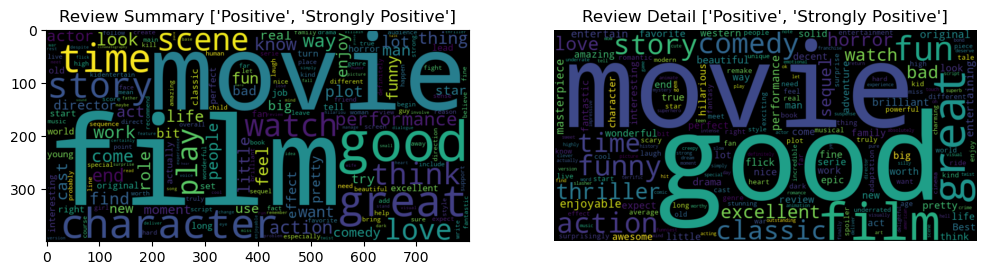

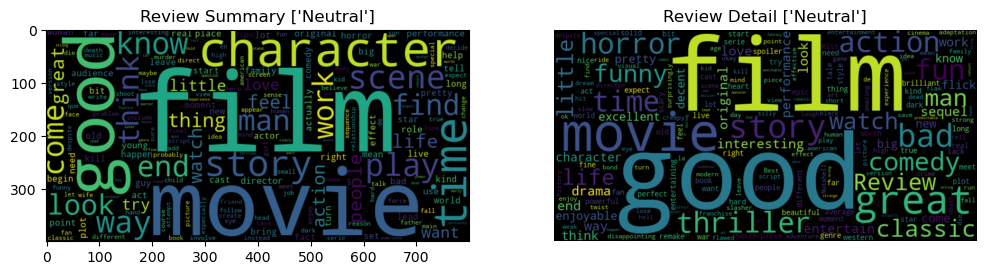

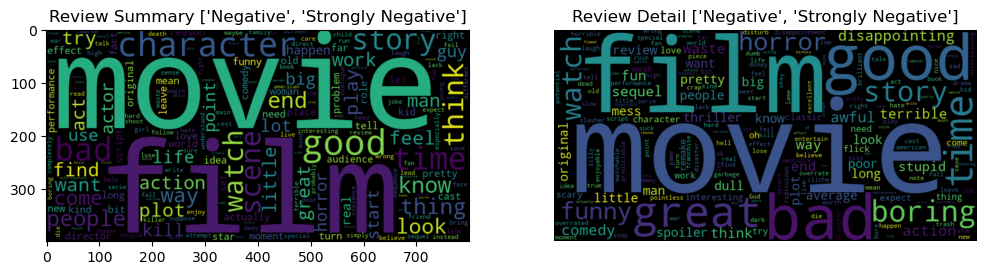

In [291]:
# Generate word clouds the can help to visualize the most frequent words in the review_details and review_summary columns
sentiment_list = [['Positive', 'Strongly Positive'], ['Neutral'], ['Negative', 'Strongly Negative']]

for sentiment in sentiment_list:
    query_result = movie_reviews_df2.query("roberta_sentiment in " + str(sentiment))
    wordcloud_detail = WordCloud(width=800, height=400, collocations=False).generate(' '.join(query_result['review_summary']))
    wordcloud_summary = WordCloud(width=800, height=400, collocations=False).generate(' '.join(query_result['review_detail']))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_summary, interpolation='bilinear')
    plt.title('Review Summary ' + str(sentiment))    

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_detail, interpolation='bilinear')
    plt.title('Review Detail ' + str(sentiment))

    plt.axis('off')
    plt.show()

#### __For Feature Engineering and Selection__:

In [292]:
# Combine 'positive' and 'strongly positive' reviews, and 'negative' and 'strongly negative' reciews
movie_reviews_df2['roberta_sentiment'] = movie_reviews_df2['roberta_sentiment'].replace('Strongly Positive', 'Positive')
movie_reviews_df2['roberta_sentiment'] = movie_reviews_df2['roberta_sentiment'].replace('Strongly Negative', 'Negative')
movie_reviews_df2['roberta_sentiment'].value_counts().unique

<bound method Series.unique of Positive    251755
Neutral     157375
Negative    121294
Name: roberta_sentiment, dtype: int64>

In [294]:
encoder = LabelEncoder()
movie_reviews_df2['roberta_sentiment_encoded'] = encoder.fit_transform(movie_reviews_df2['roberta_sentiment'])
movie_reviews_df2.head(5)

,imdb_id,review_summary,review_detail,roberta_sentiment,review_year,roberta_sentiment_encoded
0,114709,,animation experimental animation company track...,Positive,2005,2
1,114709,childhood favourite,movie hold lot good childhood memory cinema ch...,Positive,2014,2
2,114709,good hope,like movie film cast like merit film story cut...,Neutral,2014,1
3,114709,First Toy Story favorite,far come movie like spooky movie think hear in...,Positive,2014,2
4,114709,classic friendship story,wow favorite voice work movie great natural am...,Positive,2017,2


## Model Creation

In [299]:
# Combine 'cleaned_review_summary' and 'cleaned_review_detail' into a single text feature
x = movie_reviews_df2['review_summary'] + ' ' + movie_reviews_df2['review_detail']
y = movie_reviews_df2['roberta_sentiment_encoded'].values

print(f"Independent Features: {x.shape}")
print(f"Dependent Features: {y.shape}")

Independent Features: (530424,)
Dependent Features: (530424,)


In [300]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer()
x_train_vect = vectorizer.fit_transform(x_train)
x_test_vect = vectorizer.transform(x_test)

In [323]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [2.5,3,3.5]}

multinomial_nb_model = MultinomialNB()
grid_search = GridSearchCV(estimator=multinomial_nb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_vect, y_train)
best_alpha = grid_search.best_params_['alpha']
final_model = MultinomialNB(alpha=best_alpha)
final_model.fit(x_train_vect, y_train)
predictions_multinomial = final_model.predict(x_test_vect)

# # Multinomial Naive Bayes
# multinomial_nb_model = MultinomialNB()
# multinomial_nb_model.fit(x_train_vect, y_train)
# predictions_multinomial = multinomial_nb_model.predict(x_test_vect)

In [324]:
final_model

MultinomialNB(alpha=2.5)

## Model Evaluation

In [325]:
# Evaluate Multinomial Naive Bayes
accuracy_multinomial = accuracy_score(y_test, predictions_multinomial)
print("Multinomial Naive Bayes:")
print(f"Accuracy: {accuracy_multinomial:.2f}")
print(classification_report(y_test, predictions_multinomial))

Multinomial Naive Bayes:
Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.68      0.66      0.67     36509
           1       0.62      0.56      0.59     47216
           2       0.77      0.83      0.80     75403

    accuracy                           0.71    159128
   macro avg       0.69      0.68      0.69    159128
weighted avg       0.70      0.71      0.71    159128



## References
- https://medium.com/analytics-vidhya/text-preprocessing-nlp-basics-430d54016048
- https://towardsdatascience.com/how-to-preprocess-social-media-data-and-text-messages-b011efacf74
- https://towardsdatascience.com/5-lesser-known-python-libraries-for-your-next-nlp-project-ff13fc652553
- https://medium.com/coinmonks/remaking-of-shortened-sms-tweet-post-slangs-and-word-contraction-into-sentences-nlp-7bd1bbc6fcff
- https://sunscrapers.com/blog/9-best-python-natural-language-processing-nlp/
- https://towardsdatascience.com/stemming-vs-lemmatization-2daddabcb221
- https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#google_vignette
- https://atilaycemsamiloglu.medium.com/what-is-lemmatization-2d7a87f42c55
- https://support.prodi.gy/t/how-to-tell-spacy-not-to-split-any-intra-hyphen-words/1456
- https://towardsdatascience.com/elegant-text-pre-processing-with-nltk-in-sklearn-pipeline-d6fe18b91eb8
- https://python.plainenglish.io/optimize-your-spacy-ner-results-with-this-simple-change-e59937c411ab